In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

In [2]:
image_size= 64
transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(0.5,0.5),
                           ])

#dataset = datasets.ImageFolder(root='dataset/img_align_celeba', transform=transform)
dataset = datasets.MNIST(root='./data',download=True, train=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 88774013.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 60537578.12it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28822939.51it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20440481.51it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



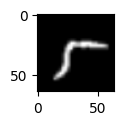

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(1,1))
plt.imshow(next(iter(dataloader))[0][0].permute((1,2,0)), cmap='gray')

In [4]:
dataset.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [30]:
import torch
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img+1, features_d, kernel_size=4, stride=2, padding=1), #32x32
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1), #16x16
            self._block(features_d * 2, features_d * 4, 4, 2, 1), #8x8
            self._block(features_d * 4, features_d * 8, 4, 2, 1),#4x4
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),

        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim=1)
        #print('Shape in disc after concatenation: ',x.shape)
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes, embed_size):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise+embed_size, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

        self.embed = nn.Embedding(num_classes, embed_size)


    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 100,1,1)

        x = torch.cat([x, embedding], dim=1)

        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


In [15]:
def gradient_penalty(disc, labels, real, fake, device='cpu'):
  BATCH_SIZE, C, H, W = real.shape
  alpha = torch.rand((BATCH_SIZE,1,1,1)).repeat(1,C,H,W).to(device)
  interpolated_image = real*alpha + fake*(1-alpha)

  mixed_score = disc(interpolated_image, labels)

  gradient = torch.autograd.grad(
      inputs = interpolated_image,
      outputs = mixed_score,
      grad_outputs = torch.ones_like(mixed_score),
      create_graph=True,
      retain_graph = True
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_norm = gradient.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient_norm-1)**2)
  return gradient_penalty

In [7]:
import torch
torch.cuda.is_available()

True

In [33]:
import torchvision.utils as vutils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 15
FEATURES_DISC = 16
FEATURES_GEN = 16
NUM_CLASSES = 10
EMBED_SIZE = 100
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

print(device)

gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, EMBED_SIZE).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC, NUM_CLASSES, IMAGE_SIZE).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
#opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
#opt_disc = optim.RMSprop(disc.parameters(), lr=LEARNING_RATE)


sample_dir = 'samples_final'
sample_dir2 = 'samples_single_final'
os.makedirs(sample_dir, exist_ok=True)
os.makedirs(sample_dir2, exist_ok=True)
fixed_noise = torch.randn(64, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

for epoch in tqdm(range(NUM_EPOCHS)):

    for batch_idx, (real, labels) in enumerate(dataloader):

        real = real.to(device)
        labels = labels.to(device)

        for a in range(CRITIC_ITERATIONS):
          noise = torch.randn(real.shape[0], NOISE_DIM, 1, 1).to(device)
          fake = gen(noise, labels)


          disc_real = disc(real, labels).reshape(-1)

          disc_fake = disc(fake.detach(), labels).reshape(-1)

          gp = gradient_penalty(disc, labels, real, fake, device=device)


          loss_disc = (-(torch.mean(disc_real) - torch.mean(disc_fake)) + LAMBDA_GP * gp)


          disc.zero_grad()
          loss_disc.backward(retain_graph=True)
          opt_disc.step()



        #gen training

        output = disc(fake, labels).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()


        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise, labels)

                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=False)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=False)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

                vutils.save_image(fake, os.path.join(sample_dir,f'Fake_sample_epoch{epoch}_{batch_idx}.png'), nrow=8, normalize=True)
                vutils.save_image(fake[23], os.path.join(sample_dir2,f'Fake_sample_epoch_single{epoch}_{batch_idx}.png'), nrow=8, normalize=True)

            step += 1
    torch.save(gen.state_dict(), 'generator_weights.pth')
    torch.save(disc.state_dict(), 'discriminator_weights.pth')


cuda


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [0/15] Batch 0/938                   Loss D: -1.7589, loss G: 1.3332
Epoch [0/15] Batch 100/938                   Loss D: -110.8805, loss G: 65.6330
Epoch [0/15] Batch 200/938                   Loss D: -128.0389, loss G: 90.5685
Epoch [0/15] Batch 300/938                   Loss D: -121.4838, loss G: 105.6361
Epoch [0/15] Batch 400/938                   Loss D: -106.6511, loss G: 110.1062
Epoch [0/15] Batch 500/938                   Loss D: -91.0942, loss G: 91.6764
Epoch [0/15] Batch 600/938                   Loss D: -76.9755, loss G: 86.7015
Epoch [0/15] Batch 700/938                   Loss D: -60.5552, loss G: 82.7433
Epoch [0/15] Batch 800/938                   Loss D: -48.1536, loss G: 76.7719
Epoch [0/15] Batch 900/938                   Loss D: -40.1262, loss G: 85.9666


  7%|▋         | 1/15 [02:39<37:18, 159.89s/it]

Epoch [1/15] Batch 0/938                   Loss D: -34.5478, loss G: 84.1248
Epoch [1/15] Batch 100/938                   Loss D: -26.5727, loss G: 80.8496
Epoch [1/15] Batch 200/938                   Loss D: -20.9212, loss G: 84.9444
Epoch [1/15] Batch 300/938                   Loss D: -15.6502, loss G: 84.9357
Epoch [1/15] Batch 400/938                   Loss D: -11.4652, loss G: 76.1377
Epoch [1/15] Batch 500/938                   Loss D: -8.3295, loss G: 70.9632
Epoch [1/15] Batch 600/938                   Loss D: -6.7145, loss G: 75.7194
Epoch [1/15] Batch 700/938                   Loss D: -6.6871, loss G: 67.8046
Epoch [1/15] Batch 800/938                   Loss D: -5.1862, loss G: 65.7410
Epoch [1/15] Batch 900/938                   Loss D: -4.5279, loss G: 60.5032


 13%|█▎        | 2/15 [05:19<34:33, 159.52s/it]

Epoch [2/15] Batch 0/938                   Loss D: -8.1947, loss G: 59.6624
Epoch [2/15] Batch 100/938                   Loss D: -5.6818, loss G: 53.8888
Epoch [2/15] Batch 200/938                   Loss D: -5.0098, loss G: 56.1415
Epoch [2/15] Batch 300/938                   Loss D: -4.1070, loss G: 54.9292
Epoch [2/15] Batch 400/938                   Loss D: -6.8149, loss G: 57.8860
Epoch [2/15] Batch 500/938                   Loss D: -4.9371, loss G: 54.7348
Epoch [2/15] Batch 600/938                   Loss D: -5.1569, loss G: 48.0334
Epoch [2/15] Batch 700/938                   Loss D: -3.5626, loss G: 45.7161
Epoch [2/15] Batch 800/938                   Loss D: -5.4694, loss G: 46.8226
Epoch [2/15] Batch 900/938                   Loss D: -2.6350, loss G: 46.4053


 20%|██        | 3/15 [07:57<31:49, 159.17s/it]

Epoch [3/15] Batch 0/938                   Loss D: -4.4813, loss G: 43.4304
Epoch [3/15] Batch 100/938                   Loss D: -4.5658, loss G: 36.4753
Epoch [3/15] Batch 200/938                   Loss D: -4.6231, loss G: 43.7423
Epoch [3/15] Batch 300/938                   Loss D: -5.3739, loss G: 45.5853
Epoch [3/15] Batch 400/938                   Loss D: -4.1768, loss G: 39.5663
Epoch [3/15] Batch 500/938                   Loss D: -3.8927, loss G: 44.3669
Epoch [3/15] Batch 600/938                   Loss D: -3.8184, loss G: 40.6210
Epoch [3/15] Batch 700/938                   Loss D: -6.3879, loss G: 31.8797
Epoch [3/15] Batch 800/938                   Loss D: -3.0869, loss G: 36.1329
Epoch [3/15] Batch 900/938                   Loss D: -2.9632, loss G: 36.8099


 27%|██▋       | 4/15 [10:37<29:13, 159.40s/it]

Epoch [4/15] Batch 0/938                   Loss D: -2.7420, loss G: 36.7839
Epoch [4/15] Batch 100/938                   Loss D: -4.3664, loss G: 25.2026
Epoch [4/15] Batch 200/938                   Loss D: -2.2226, loss G: 38.8116
Epoch [4/15] Batch 300/938                   Loss D: -5.1030, loss G: 31.7453
Epoch [4/15] Batch 400/938                   Loss D: -4.6430, loss G: 34.3475
Epoch [4/15] Batch 500/938                   Loss D: -4.8091, loss G: 33.2442
Epoch [4/15] Batch 600/938                   Loss D: -4.7288, loss G: 35.5782
Epoch [4/15] Batch 700/938                   Loss D: -3.8709, loss G: 31.9037
Epoch [4/15] Batch 800/938                   Loss D: -3.5493, loss G: 15.2137
Epoch [4/15] Batch 900/938                   Loss D: -3.1608, loss G: 25.7006


 33%|███▎      | 5/15 [13:16<26:33, 159.35s/it]

Epoch [5/15] Batch 0/938                   Loss D: -2.3447, loss G: 16.4930
Epoch [5/15] Batch 100/938                   Loss D: -4.1710, loss G: 34.2453
Epoch [5/15] Batch 200/938                   Loss D: -2.9715, loss G: 37.5714
Epoch [5/15] Batch 300/938                   Loss D: -4.9603, loss G: 22.3246
Epoch [5/15] Batch 400/938                   Loss D: -2.6664, loss G: 18.1175
Epoch [5/15] Batch 500/938                   Loss D: -3.6710, loss G: 23.0555
Epoch [5/15] Batch 600/938                   Loss D: -4.7256, loss G: 25.9803
Epoch [5/15] Batch 700/938                   Loss D: -2.3024, loss G: 28.2867
Epoch [5/15] Batch 800/938                   Loss D: -3.5265, loss G: 10.9322
Epoch [5/15] Batch 900/938                   Loss D: -3.9173, loss G: 19.5035


 40%|████      | 6/15 [15:56<23:53, 159.32s/it]

Epoch [6/15] Batch 0/938                   Loss D: -2.7754, loss G: 20.4911
Epoch [6/15] Batch 100/938                   Loss D: -3.4629, loss G: 13.0742
Epoch [6/15] Batch 200/938                   Loss D: -3.4418, loss G: 14.6198
Epoch [6/15] Batch 300/938                   Loss D: -2.9028, loss G: -1.6916
Epoch [6/15] Batch 400/938                   Loss D: -2.2470, loss G: 11.7673
Epoch [6/15] Batch 500/938                   Loss D: -3.0453, loss G: 4.9995
Epoch [6/15] Batch 600/938                   Loss D: -2.5360, loss G: 21.9699
Epoch [6/15] Batch 700/938                   Loss D: -2.1441, loss G: 18.4872
Epoch [6/15] Batch 800/938                   Loss D: -2.7656, loss G: 2.2742
Epoch [6/15] Batch 900/938                   Loss D: -3.3712, loss G: 13.0828


 47%|████▋     | 7/15 [18:35<21:13, 159.25s/it]

Epoch [7/15] Batch 0/938                   Loss D: -4.0725, loss G: 11.2372
Epoch [7/15] Batch 100/938                   Loss D: -2.5470, loss G: 15.6998
Epoch [7/15] Batch 200/938                   Loss D: -3.6900, loss G: -1.5215
Epoch [7/15] Batch 300/938                   Loss D: -2.1495, loss G: -0.5118
Epoch [7/15] Batch 400/938                   Loss D: -2.9929, loss G: 8.2917


 47%|████▋     | 7/15 [19:44<22:33, 169.22s/it]


KeyboardInterrupt: 

enter number for generation: 5


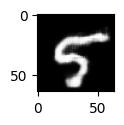

enter number for generation: 8


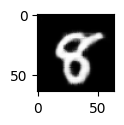

enter number for generation: 9


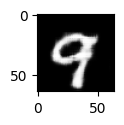

enter number for generation: 1


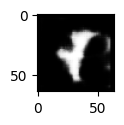

enter number for generation: 0


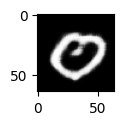

enter number for generation: 2


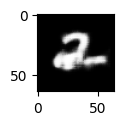

enter number for generation: 3


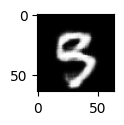

enter number for generation: 4


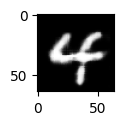

enter number for generation: 5


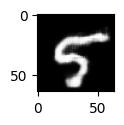

enter number for generation: 10


In [38]:
import numpy as np
import matplotlib.pyplot as plt

number = 0
while number!=10:
  number = int(input("enter number for generation: "))
  if number == 10:
    break
  labels = torch.tensor(np.full(64, number)).to(device)
  with torch.no_grad():
    generated_samples = gen(fixed_noise, labels)

  plt.figure(figsize=(1,1))
  plt.imshow(generated_samples[0].permute((1,2,0)).detach().cpu(), cmap='gray')
  plt.show()

In [36]:
import numpy as np
np.full(64,2)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
gen(fixed_noise).shape